## MNIST (static image) classification with SNNs implemented in SNNTorch
Tutorial: https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_5.html

In [1]:
from pathlib import Path

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

Matplotlib created a temporary cache directory at /tmp/matplotlib-ru3wrzz8 because the default path (/home/jupyter-ikharitonov/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
batch_size = 128
data_path = Path.home()/'RANCZLAB-NAS/iakov/data/torch_mnist'

dtype = torch.float
device = torch.device('cuda')

In [3]:
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0), (1))
])

mnist_train = datasets.MNIST(data_path, train=True, download=False, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=False, transform=transform)

In [4]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [5]:
num_inputs = 28*28
num_hidden = 28*28
num_outputs = 10

num_steps = 25
# beta = 0.95
timestep = 1/250
beta = np.exp(-timestep / 0.03)

In [6]:
beta

0.8751733190429475

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # initialise layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)
        
    def forward(self, x):
        
        # initialise hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # record the final layer
        spk2_rec = []
        mem2_rec = []
        
        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
    
class Net_frozen(nn.Module):
    def __init__(self):
        super().__init__()
        
        # initialise layers
        self.fc1 = nn.Linear(num_inputs, num_hidden, bias=False)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs, bias=False)
        # self.fc2.weight.data = torch.ones_like(self.fc2.weight.data)
        self.lif2 = snn.Leaky(beta=beta)
        
    def forward(self, x):
        
        # initialise hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # record the final layer
        spk2_rec = []
        mem2_rec = []
        
        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# net = Net().to(device)
net = Net_frozen().to(device)
# net.fc2.weight.requires_grad_(False)

In [8]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1)) # flattening the data and applying forward pass
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())
    
    if train:
        print(f'Train set accuracy for a single minibatch: {acc*100:.2f}%')
    else:
        print(f'Test set accuracy for a single minibatch: {acc*100:.2f}%')
    
def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [9]:
for i in net.named_parameters():
    print(i[0])

fc1.weight
fc2.weight


In [10]:
loss = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [11]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

In [12]:
spk_rec, mem_rec = net(data.view(batch_size, -1))

In [13]:
print(mem_rec.size())

torch.Size([25, 128, 10])


In [14]:
loss_val = torch.zeros((1), dtype=dtype, device=device) # initialise the total loss value

for step in range(num_steps):
    loss_val += loss(mem_rec[step], targets)

In [15]:
print(f"Training loss: {loss_val.item():.3f}")

Training loss: 57.822


In [16]:
print_batch_accuracy(data, targets, train=True)

Train set accuracy for a single minibatch: 8.59%


In [17]:
# single weight update

optimizer.zero_grad() # clear previously stored gradients
loss_val.backward() # calculate the gradients
optimizer.step() # weight update

In [18]:
spk_rec, mem_rec = net(data.view(batch_size, -1))

loss_val = torch.zeros((1), dtype=dtype, device=device)

for step in range(num_steps):
    loss_val += loss(mem_rec[step], targets)

In [19]:
print(f'Training loss: {loss_val.item(): .3f}') # LIF membrane potential is used for loss cross entropy loss
print_batch_accuracy(data, targets, train=True) # and spike count is used for the measure of accuracy

Training loss:  49.033
Train set accuracy for a single minibatch: 24.22%


In [20]:
# TRAINING LOOP

num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

for epoch  in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)
    
    # Minibatch training loop
    for data, targets in train_batch:
        data, targets = data.to(device), targets.to(device)
        
        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))
        
        # initialise the loss and sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)
        
        # gradient calculation and weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        
        loss_hist.append(loss_val.item())
        
        # test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data, test_targets = test_data.to(device), test_targets.to(device)
            
            test_spk, test_mem = net(test_data.view(batch_size, -1))
            
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())
            
            # train/test loss/accuracy print
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter += 1

Epoch 0, Iteration 0
Train Set Loss: 53.38
Test Set Loss: 49.01
Train set accuracy for a single minibatch: 35.16%
Test set accuracy for a single minibatch: 27.34%


Epoch 0, Iteration 50
Train Set Loss: 13.13
Test Set Loss: 10.22
Train set accuracy for a single minibatch: 87.50%
Test set accuracy for a single minibatch: 93.75%


Epoch 0, Iteration 100
Train Set Loss: 10.11
Test Set Loss: 11.40
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 90.62%


Epoch 0, Iteration 150
Train Set Loss: 9.95
Test Set Loss: 7.55
Train set accuracy for a single minibatch: 89.06%
Test set accuracy for a single minibatch: 91.41%


Epoch 0, Iteration 200
Train Set Loss: 8.38
Test Set Loss: 5.31
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 93.75%


Epoch 0, Iteration 250
Train Set Loss: 7.25
Test Set Loss: 8.13
Train set accuracy for a single minibatch: 93.75%
Test set accuracy for a single minibatch: 89.84%


Epoch 0

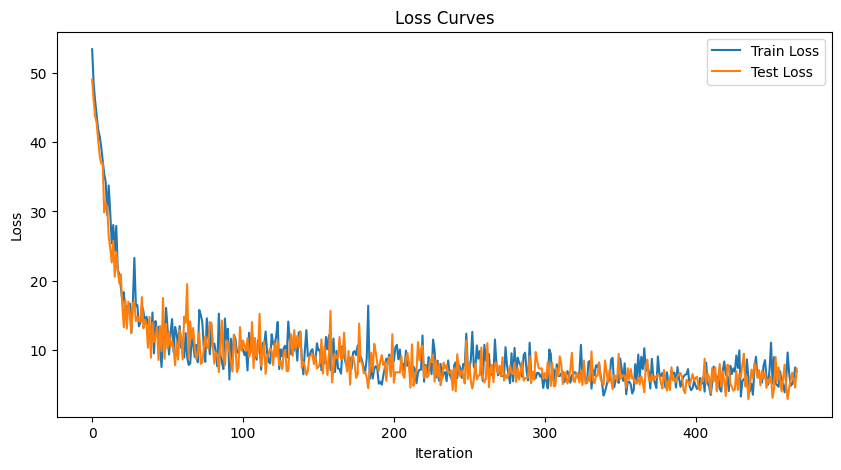

In [21]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [22]:
# full test set accuracy

total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9422/10000
Test Set Accuracy: 94.22%


In [23]:
net

Net_frozen(
  (fc1): Linear(in_features=784, out_features=784, bias=False)
  (lif1): Leaky()
  (fc2): Linear(in_features=784, out_features=10, bias=False)
  (lif2): Leaky()
)

In [24]:
net.fc1.weight.data.shape

torch.Size([784, 784])

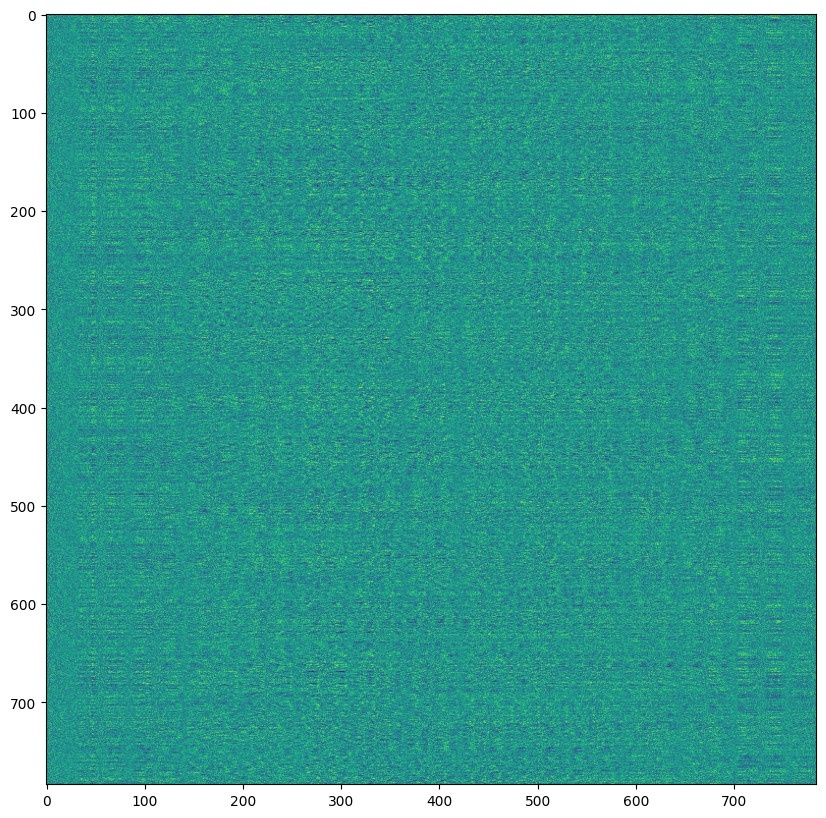

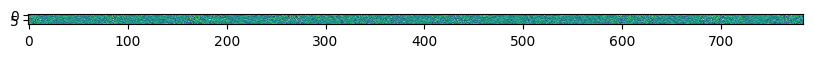

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(net.fc1.weight.data.detach().cpu().numpy())
plt.show()

plt.figure(figsize=(10,20))
plt.imshow(net.fc2.weight.data.detach().cpu().numpy())
plt.show()

In [26]:
targets.shape

torch.Size([16])

In [28]:
np.save(Path.home()/'RANCZLAB-NAS/iakov/produced/classification_task_weights/mnist_classification_weights_matrix.npy', net.fc1.weight.data.detach().cpu().numpy())
np.save(Path.home()/'RANCZLAB-NAS/iakov/produced/classification_task_weights/fc2.npy', net.fc1.weight.data.detach().cpu().numpy())
np.save(Path.home()/'RANCZLAB-NAS/iakov/produced/classification_task_weights/fc_out.npy', net.fc2.weight.data.detach().cpu().numpy())